# Exploring microbial diversity with DADA2 and phyloseq in R

**Microbiomes**, the collection of microbes which comprise particular environments, are of increasing importance to both human and environmental health. Microbes are found in or on many human tissues and fluids, including on our skin and in our mouths and digestive tracts. Furthermore, microbes are essentially involved in elemental cycling and ecological maintainence. Assessing the taxonomic profile of these microbial communities is important for understanding human digestive and immunological health in addition to understanding the ecological and metabolic role of microbes in environmental settings.

*Culture-independent* microbiological techniques have recently broken the limited, culture-dependent paradigm of microbiology by making possible the analysis of DNA extracted directly from a sample rather than from individually cultured microbes. Additionally, the development of high-throughput sequencing techniques over the last 15 years has made it economically feasible to quickly and cheaply investigate many aspects of microbial communities, including *taxonomic diversity* (how many of which microbes are present in a community) and *functional metagenomics* (what are the biological/biochemical capabilities of the members of a microbial community). 

Assessing the taxonomic diversity of an environmental sample involves identifying marker genes which can be used to identify particular species. A good marker gene is present in all members of a population, should differ only and always between taxonomically unique individuals, and should ideally differ in proportion to the evolutionary distance between individuals. A handful of marker genes are known and used, but the most common marker gene is the **16S ribosomal RNA subunit gene**. Sequencing the 16S rRNA genes of a microbiome is a relatively cheap and simple procedure. Once a collection of 16S rRNA sequences have been identified for a sample, they can be referenced against a database of microbial metadata (including the 16S rRNA sequences for particular species) to determine the taxonomic composition of a given sample.

<img src="microbiome.png" width="300"/>

This is a workflow for denoising, filtering, trimming, dereplicating, sample inference, taxonomic characterization, and visualization of microbiome data using the DADA2 and phyloseq packages in R. This publically available dataset is the result of a longitudinal study of the fecal samples of 12 mice over the first year of life which investigated the development and stabilization of the murine microbiome following weaning (Schloss et al., 2012). In this workflow, we will start with raw reads and end with an assessment of the taxonomic diversity and composition of these samples.

### Loading in the data

In [1]:
# load in the necessary packages
suppressMessages(library("knitr"))
suppressMessages(library("BiocStyle"))
suppressMessages(library("dada2"))
suppressMessages(library('ggplot2'))
suppressMessages(library("phyloseq"))
suppressMessages(library("DECIPHER"))
suppressMessages(library("phangorn"))

In [2]:
set.seed(100)

In [3]:
# accessing the data
miseq.path <- "/Users/dgagler/School/BIOINFORMATICS/MiSeq_SOP"

In [4]:
list.files(miseq.path)

[1] "F3D0_S188_L001_R1_001.fastq"   "F3D0_S188_L001_R2_001.fastq"  
 [3] "F3D1_S189_L001_R1_001.fastq"   "F3D1_S189_L001_R2_001.fastq"  
 [5] "F3D141_S207_L001_R1_001.fastq" "F3D141_S207_L001_R2_001.fastq"
 [7] "F3D142_S208_L001_R1_001.fastq" "F3D142_S208_L001_R2_001.fastq"
 [9] "F3D143_S209_L001_R1_001.fastq" "F3D143_S209_L001_R2_001.fastq"
[11] "F3D144_S210_L001_R1_001.fastq" "F3D144_S210_L001_R2_001.fastq"
[13] "F3D145_S211_L001_R1_001.fastq" "F3D145_S211_L001_R2_001.fastq"
[15] "F3D146_S212_L001_R1_001.fastq" "F3D146_S212_L001_R2_001.fastq"
[17] "F3D147_S213_L001_R1_001.fastq" "F3D147_S213_L001_R2_001.fastq"
[19] "F3D148_S214_L001_R1_001.fastq" "F3D148_S214_L001_R2_001.fastq"
[21] "F3D149_S215_L001_R1_001.fastq" "F3D149_S215_L001_R2_001.fastq"
[23] "F3D150_S216_L001_R1_001.fastq" "F3D150_S216_L001_R2_001.fastq"
[25] "F3D2_S190_L001_R1_001.fastq"   "F3D2_S190_L001_R2_001.fastq"  
[27] "F3D3_S191_L001_R1_001.fastq"   "F3D3_S191_L001_R2_001.fastq"  
[29] "F3D5_S193_L001_R1_001.fastq"   "F3D5_S193_L001_R2_001.fastq"  
[31] "F3D6_S194_L001_R1_001.fastq"   "F3D6_S194_L001_R2_001.fastq"  
[33] "F3D7_S195_L001_R1_001.fastq"   "F3D7_S195_L001_R2_001.fastq"  
[35] "F3D8_S196_L001_R1_001.fastq"   "F3D8_S196_L001_R2_001.fastq"  
[37] "F3D9_S197_L001_R1_001.fastq"   "F3D9_S197_L001_R2_001.fastq"  
[39] "filtered"                      "HMP_MOCK.v35.fasta"           
[41] "Mock_S280_L001_R1_001.fastq"   "Mock_S280_L001_R2_001.fastq"  
[43] "mouse.dpw.metadata"            "mouse.time.design"            
[45] "rdp_train_set_16.fa"           "rdp_train_set_16.fa.gz"       
[47] "stability.batch"               "stability.files"

### Filtering and Trimming
Here, we sort our fastq files into lists of forward and reverse reads with matching order, which will be relevant for downstream analysis. Afterwards, we will assess the quality of our sequences and trim them accordingly.

In [5]:
# sort forward/reverse reads to put them in the same order
fwds <- sort(list.files(miseq.path, pattern="_R1_001.fastq"))
revs <- sort(list.files(miseq.path, pattern="_R2_001.fastq"))
# extract sample names, assuming filenames have format: SAMPLENAME_XXX.fastq
sampleNames <- sapply(strsplit(fwds, "_"), `[`, 1)
# specify the full path to the forward and reverse reads
fwds <- file.path(miseq.path, fwds)
revs <- file.path(miseq.path, revs)

The forward reads in this dataset are of high quality throughout. The DADA2 pipeline tutorial suggests trimming the last 10 nucleotides to avoid pathological errors which can arise there. For this reason, we will trim the forward reads at position 240. whereas the reverse reads exhibit steep dropoffs in quality around position 150. Furthermore, we will trim the 10 nucleotides of each sequence.

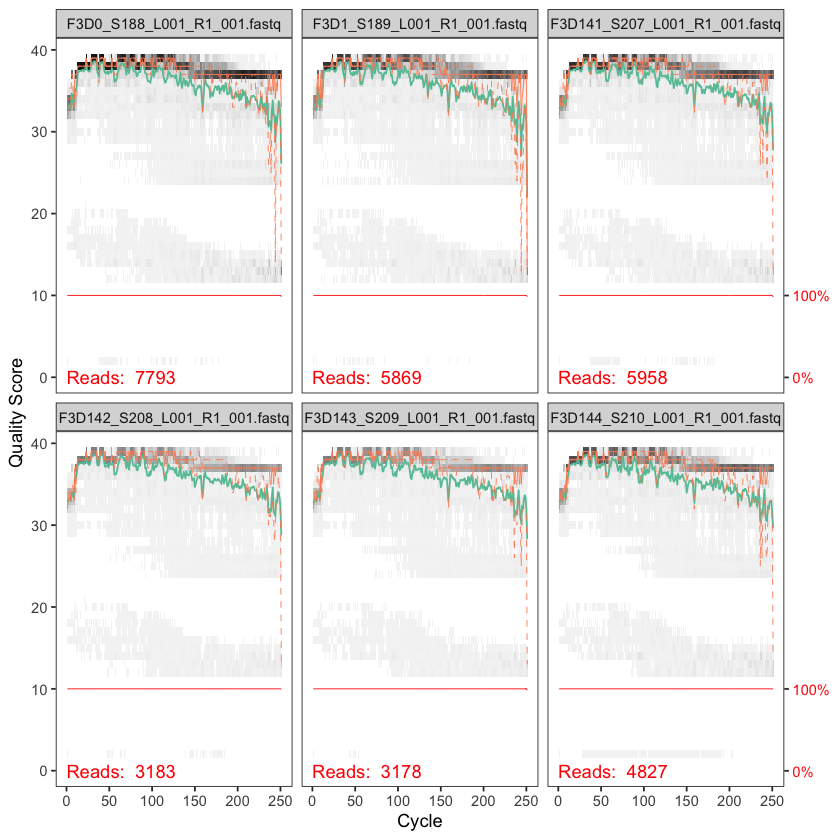

In [6]:
plotQualityProfile(fwds[1:6])

**Figure 1:** Quality profiles of the forward reads of the first 6 samples. The mean quality score is depicted by the green lines and the quartiles of the quality score distribution by the orange.

As seen above, the forward reads in this dataset are of high quality throughout. The DADA2 pipeline tutorial suggests trimming the last 10 nucleotides to avoid errors which can arise there. For this reason, we will trim the forward reads at position 240.

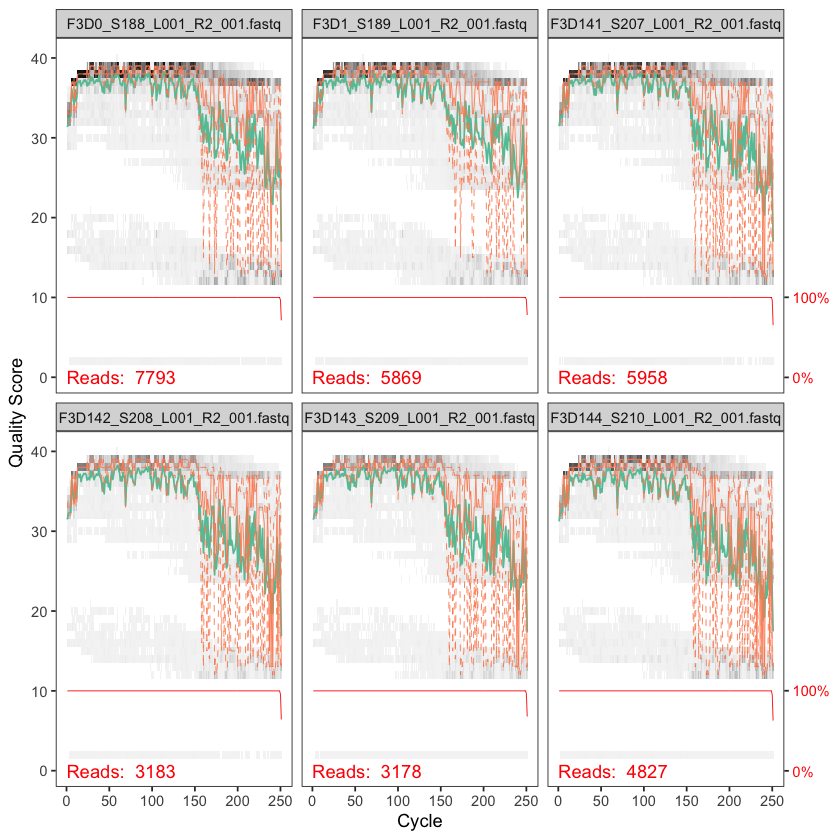

In [7]:
plotQualityProfile(revs[1:6])

**Figure 2:** Quality profiles of the reverse reads of the first 6 samples. The mean quality score is depicted by the green lines and the quartiles of the quality score distribution by the orange.

Unlike the forward reads, the reverse reads drop precipitously in quality. A decrease in quality in later positions is not uncommon with Illumina sequencing data. As such, we will trim the reverse reads at position 160.

In [8]:
# place filtered files in filtered/ subdirectory
filt.path <- file.path(miseq.path, "filtered") 
if(!file_test("-d", filt.path)) dir.create(filt.path)
filtFs <- file.path(filt.path, paste0(sampleNames, "_F_filt.fastq"))
filtRs <- file.path(filt.path, paste0(sampleNames, "_R_filt.fastq"))

In [9]:
# filter and trim the reads using our quality score thresholds and standard filtering parameters
# the maxEE parameter sets the maximum number of expected errors allowed in a read, which acts as a quality filter

out <- filterAndTrim(fwds, filtFs, revs, filtRs, truncLen=c(240,160),
              maxN=0, maxEE=c(2,2), truncQ=2, rm.phix=TRUE,
              compress=TRUE, multithread=TRUE)
head(out)

,reads.in,reads.out
F3D0_S188_L001_R1_001.fastq,7793,7113
F3D1_S189_L001_R1_001.fastq,5869,5299
F3D141_S207_L001_R1_001.fastq,5958,5463
F3D142_S208_L001_R1_001.fastq,3183,2914
F3D143_S209_L001_R1_001.fastq,3178,2941
F3D144_S210_L001_R1_001.fastq,4827,4312


## Inferring ASVs
Analyzing 16S rRNA genes to determine taxonomy typically involves "binning" DNA sequences into **Operational Taxonomic Units** (OTUs) based on some threshold of marker sequence similarity, typically somewhere between 95% and 99% similarity. At this point, these OTUs take the place of "species" in taxonomic analyses because named species genomes are not always available for every marker sequence. Binning a community into discrete OTUs opens the door to many computationally tractable ways to represent the taxonomic diversity of a sample, such as into histograms, bar plots, or phylogenetic trees.

After filtering, most standard bioinformatic workflows will cluster reads into OTUs: groups of reads which meet some threshold of similarity. Instead of OTUs, the DADA2 method infers Amplicon Sequence Variants (ASVs). This method doesn't require an externally imposed threshold of similarity and instead identifies each sequence variant, thus providing a finer tool for resolving differences in marker gene sequences.

### Dereplication
To infer our ASVs, we must first *dereplicate* our sequences. Dereplication reduces computational stress by collapsing identical sequence reads into a single object with an associated abundance count, thereby eliminating redundant sequence comparisons.

In [10]:
suppressMessages(derepFs <- derepFastq(filtFs, verbose=TRUE))
suppressMessages(derepRs <- derepFastq(filtRs, verbose=TRUE))
# name the derep-class objects by the sample names
names(derepFs) <- sampleNames
names(derepRs) <- sampleNames

### Learning error rates
The DADA2 algorithm for inferring sequence variants uses an parameterized error model in order to distinguish between sequencing errors and actual biological variation. We determine the model parameters (error rates) by using a form of unsupervised learning on the dataset itself.

In [11]:
errF <- learnErrors(filtFs, multithread=TRUE)

33514080 total bases in 139642 reads from 20 samples will be used for learning the error rates.


In [12]:
errR <- learnErrors(filtRs, multithread=TRUE)

22342720 total bases in 139642 reads from 20 samples will be used for learning the error rates.


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


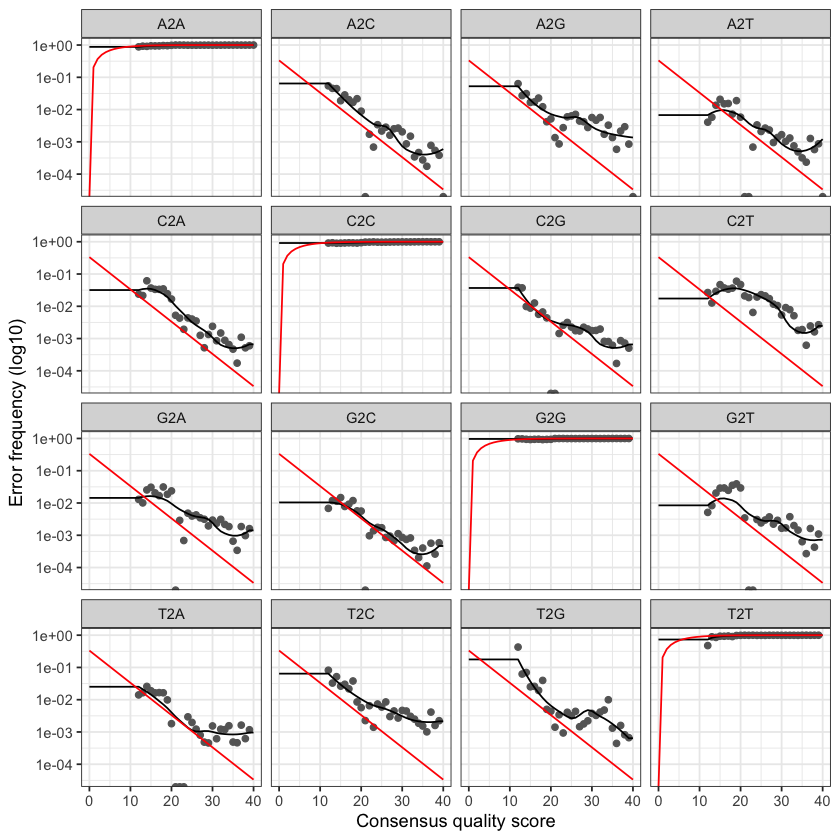

In [13]:
plotErrors(errF, nominalQ=TRUE)

**Figure 3:** These plots show the estimated error rates for each possible nucleotide transition (A -> C, A -> G, etc.) in the forward reads. Observed error rates are shown as black points and fitted error rates are shown as black lines. Furthermore, the red line depicts the standard expected error rate for a given quality score. 

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


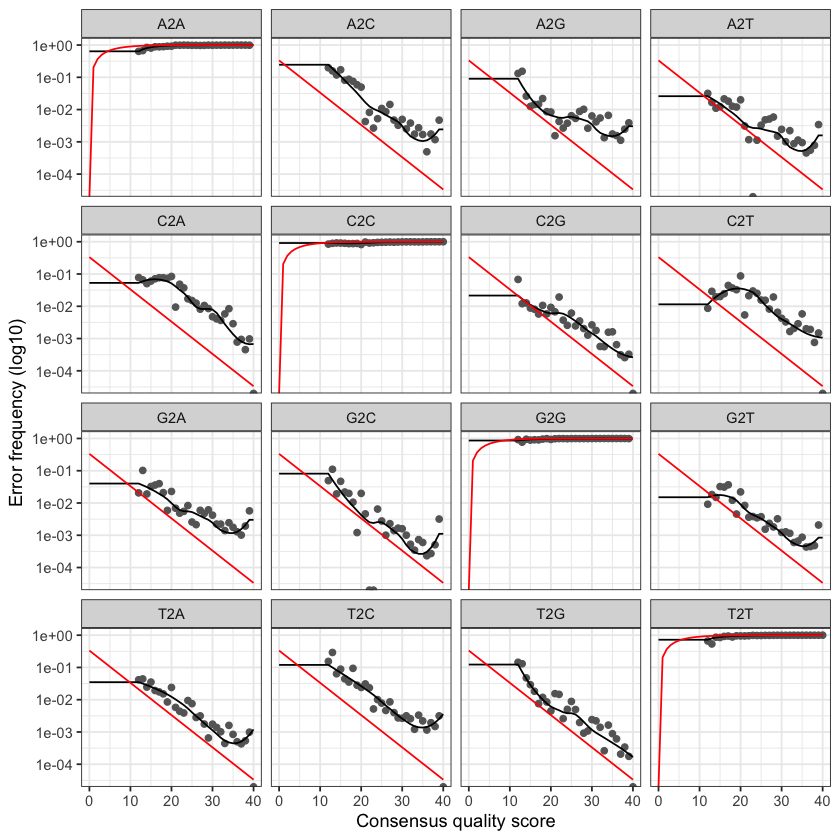

In [14]:
plotErrors(errR, nominalQ=TRUE)

**Figure 4:** These plots show the estimated error rates for each possible nucleotide transition (A -> C, A -> G, etc.) in the reverse reads. Observed error rates are shown as black points and fitted error rates are shown as black lines. Furthermore, the red line depicts the standard expected error rate for a given quality score. 

We can see from Figures 3 and 4 that our fitted error rates estimate the observed errors well and that the error rates decrease as a function of quality score, as one would expect.

### Sample Inference
Now we will apply the core DADA2 algorithm for sample inference to our filtered, trimmed, and dereplicated sequence data. We pool our sequences by setting the multithread parameter to true. Pooled sequence inference is more computationally intensive but improves the detection of rare variants. As this dataset is not particularly large, we chose to pool our sequences by setting the multithread parameter as true.

In [15]:
### forward reads
dadaFs <- dada(derepFs, err=errF, multithread=TRUE)

Sample 1 - 7113 reads in 1979 unique sequences.
Sample 2 - 5299 reads in 1639 unique sequences.
Sample 3 - 5463 reads in 1477 unique sequences.
Sample 4 - 2914 reads in 904 unique sequences.
Sample 5 - 2941 reads in 939 unique sequences.
Sample 6 - 4312 reads in 1267 unique sequences.
Sample 7 - 6741 reads in 1756 unique sequences.
Sample 8 - 4560 reads in 1438 unique sequences.
Sample 9 - 15637 reads in 3590 unique sequences.
Sample 10 - 11413 reads in 2762 unique sequences.
Sample 11 - 12017 reads in 3021 unique sequences.
Sample 12 - 5032 reads in 1566 unique sequences.
Sample 13 - 18075 reads in 3707 unique sequences.
Sample 14 - 6250 reads in 1479 unique sequences.
Sample 15 - 4052 reads in 1195 unique sequences.
Sample 16 - 7369 reads in 1832 unique sequences.
Sample 17 - 4765 reads in 1183 unique sequences.
Sample 18 - 4871 reads in 1382 unique sequences.
Sample 19 - 6504 reads in 1709 unique sequences.
Sample 20 - 4314 reads in 897 unique sequences.


In [16]:
### reverse reads
dadaRs <- dada(derepRs, err=errR, multithread=TRUE)

Sample 1 - 7113 reads in 1660 unique sequences.
Sample 2 - 5299 reads in 1349 unique sequences.
Sample 3 - 5463 reads in 1335 unique sequences.
Sample 4 - 2914 reads in 853 unique sequences.
Sample 5 - 2941 reads in 880 unique sequences.
Sample 6 - 4312 reads in 1286 unique sequences.
Sample 7 - 6741 reads in 1803 unique sequences.
Sample 8 - 4560 reads in 1265 unique sequences.
Sample 9 - 15637 reads in 3414 unique sequences.
Sample 10 - 11413 reads in 2522 unique sequences.
Sample 11 - 12017 reads in 2771 unique sequences.
Sample 12 - 5032 reads in 1415 unique sequences.
Sample 13 - 18075 reads in 3290 unique sequences.
Sample 14 - 6250 reads in 1390 unique sequences.
Sample 15 - 4052 reads in 1134 unique sequences.
Sample 16 - 7369 reads in 1635 unique sequences.
Sample 17 - 4765 reads in 1084 unique sequences.
Sample 18 - 4871 reads in 1161 unique sequences.
Sample 19 - 6504 reads in 1502 unique sequences.
Sample 20 - 4314 reads in 732 unique sequences.


### Merging Paired Reads
Now, we will merge the forward and reverse reads together to obtain full denoised sequences. Merging occurs by aligning the forward reads with the reverse compliment of the corresponding reverse reads and then constructing the merged contig sequences. 

In [17]:
mergers <- mergePairs(dadaFs, derepFs, dadaRs, derepRs)

### Constructing our sequence table
Now, we construct our Amplicon Sequence Variant (ASV) table. The sequence table takes the form of a matrix where rows correspond to samples and columns correspond to sequence variants.

In [18]:
# make the sequence table
seqtab <- makeSequenceTable(mergers)
# check the dimensions of the sequence table
dim(seqtab)
# check the distribution of the sequence lengths
table(nchar(getSequences(seqtab)))

[1]  20 293


251 252 253 254 255 
  1  88 196   6   2 

### Removing chimeras
Chimeras are artificial sequences which are formed when 2 biological sequences join together, usually somewhere in the PCR process. We now remove chimeric sequences by comparing each inferred sequence to the others in the table and removing those that can be reproduced by stitching together two more abundant sequences.

In [19]:
seqtab.nochim <- removeBimeraDenovo(seqtab, method="consensus", multithread=TRUE, verbose=TRUE)
dim(seqtab.nochim)
# checks the fraction of nonchimeric sequences
sum(seqtab.nochim)/sum(seqtab)

Identified 61 bimeras out of 293 input sequences.



[1]  20 232

[1] 0.964263

### Assigning taxonomy
DADA2 uses a naive Bayesian classifier method for assigning taxonomy via 16s rRNA genes. This classifier compares sequence variants to a training set of classified sequences. Here, we use the RDP v16 training set (Cole et al. 2009).

In [20]:
taxa <- assignTaxonomy(seqtab.nochim, "/Users/dgagler/School/BIOINFORMATICS/MiSeq_SOP/rdp_train_set_16.fa.gz", multithread=TRUE)
taxa.print <- taxa # Removing sequence rownames for display only
rownames(taxa.print) <- NULL
head(taxa.print)

Kingdom,Phylum,Class,Order,Family,Genus
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,NA
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,NA
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,NA
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Barnesiella
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,NA


# Visualizing Microbiomes with Phyloseq

The mouse dataset we used does not include any organized metadata. Instead, we will extract some basic sample information (the gender, subject number, and days after weaning for each mouse sample) which are found in the filenames in the form of GXDY where G = gender, X = subject number, and DY = days after weaning. We construct a basic dataframe with this information.

In [21]:
samples.out <- rownames(seqtab.nochim)
subject <- sapply(strsplit(samples.out, "D"), `[`, 1)
gender <- substr(subject,1,1)
subject <- substr(subject,2,999)
day <- as.integer(sapply(strsplit(samples.out, "D"), `[`, 2))
samdf <- data.frame(Subject=subject, Gender=gender, Day=day)
samdf$When <- "Early"
samdf$When[samdf$Day>100] <- "Late"
rownames(samdf) <- samples.out

And then we will create a phyloseq object using the ASV sequence table we generated using DADA2.

In [22]:
ps <- phyloseq(otu_table(seqtab.nochim, taxa_are_rows=FALSE), 
               sample_data(samdf), 
               tax_table(taxa))
ps <- prune_samples(sample_names(ps) != "Mock", ps) # remove mock sample

In [23]:
table(tax_table(ps)[, "Phylum"], exclude = NULL) # compact view of taxonomy at phylum level


             Actinobacteria               Bacteroidetes 
                          6                          20 
Candidatus_Saccharibacteria   Cyanobacteria/Chloroplast 
                          2                           3 
        Deinococcus-Thermus                  Firmicutes 
                          1                         188 
             Proteobacteria                 Tenericutes 
                          7                           1 
            Verrucomicrobia                        <NA> 
                          1                           3 

We have 3 sequences which could not be assigned any particular taxonomy which we will filter from the dataset.

In [24]:
ps <- subset_taxa(ps, !is.na(Phylum) & !Phylum %in% c("NA")) # remove NA assignments

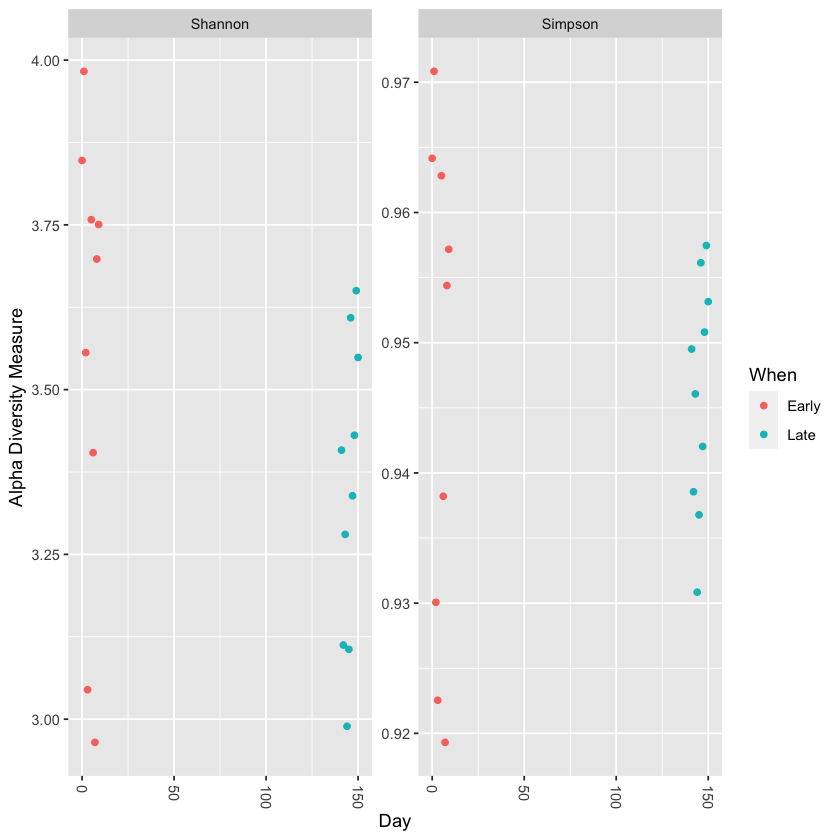

In [25]:
suppressWarnings(plot_richness(ps, x="Day", measures=c("Shannon", "Simpson"), color="When"))

**Figure 5**: Shannon and Simpson alpha-diversity for this dataset. A greater Shannon value represents greater diversity, whereas a greater Simpson value represents lesser diversity. The early and late samples do not have significantly different alpha diversity values, although the late samples in this dataset cover a smaller range in alpha-diversity than the early samples.

In [26]:
# Transform data to proportions as appropriate for Bray-Curtis distances
ps.prop <- transform_sample_counts(ps, function(otu) otu/sum(otu))
ord.nmds.bray <- ordinate(ps.prop, method="NMDS", distance="bray")

Run 0 stress 0.08002734 
Run 1 stress 0.1318142 
Run 2 stress 0.09333668 
Run 3 stress 0.08002734 
... New best solution
... Procrustes: rmse 4.409164e-06  max resid 1.159255e-05 
... Similar to previous best
Run 4 stress 0.1225891 
Run 5 stress 0.1218085 
Run 6 stress 0.1225891 
Run 7 stress 0.08490168 
Run 8 stress 0.08002734 
... New best solution
... Procrustes: rmse 1.662071e-06  max resid 3.607409e-06 
... Similar to previous best
Run 9 stress 0.08490169 
Run 10 stress 0.08490169 
Run 11 stress 0.08002734 
... Procrustes: rmse 7.121698e-06  max resid 1.928099e-05 
... Similar to previous best
Run 12 stress 0.1225891 
Run 13 stress 0.08002734 
... New best solution
... Procrustes: rmse 1.438698e-06  max resid 3.175644e-06 
... Similar to previous best
Run 14 stress 0.08855804 
Run 15 stress 0.08855802 
Run 16 stress 0.08855792 
Run 17 stress 0.08490169 
Run 18 stress 0.09333667 
Run 19 stress 0.08855792 
Run 20 stress 0.0800841 
... Procrustes: rmse 0.0068726  max resid 0.02179427

**Non-metric Multidimensional Scaling (NMDS)** is a technique for compressing multidimensional data into a 2D representation. Microbial ecologists sometimes utilize NMDS in tandem with some kind of distance measure, such as Bray-Curtis distance, to assess differences in the taxonomic composition of their samples.

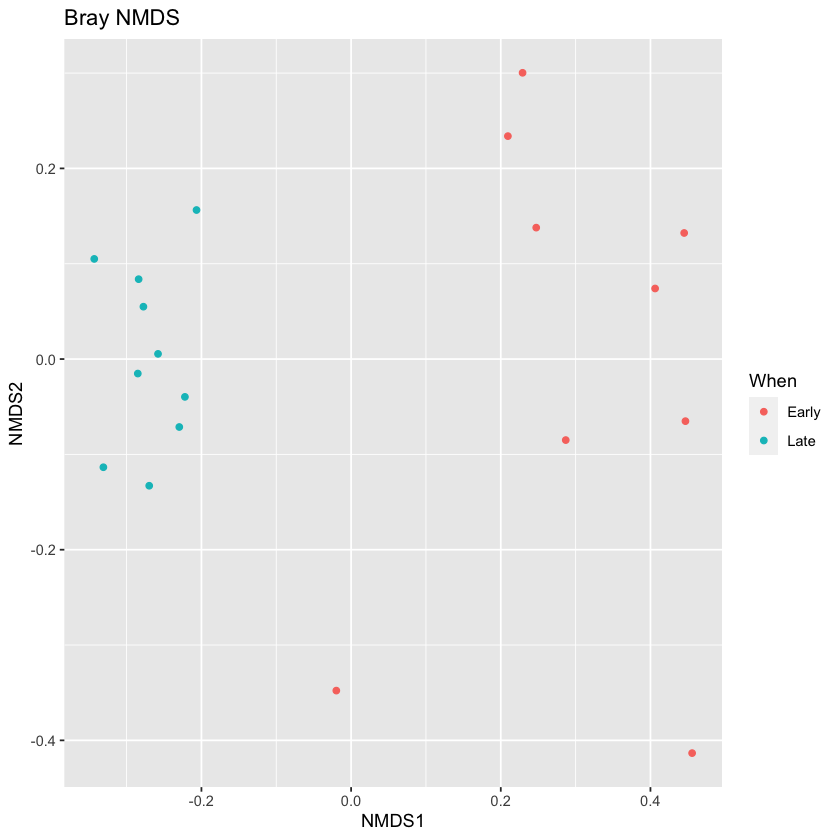

In [27]:
plot_ordination(ps.prop, ord.nmds.bray, color="When", title="Bray NMDS")

**Figure 6**: Bray-Curtis NMDS plot showing differences in species composition of our samples. Note the distinctive clustering of early and late samples.

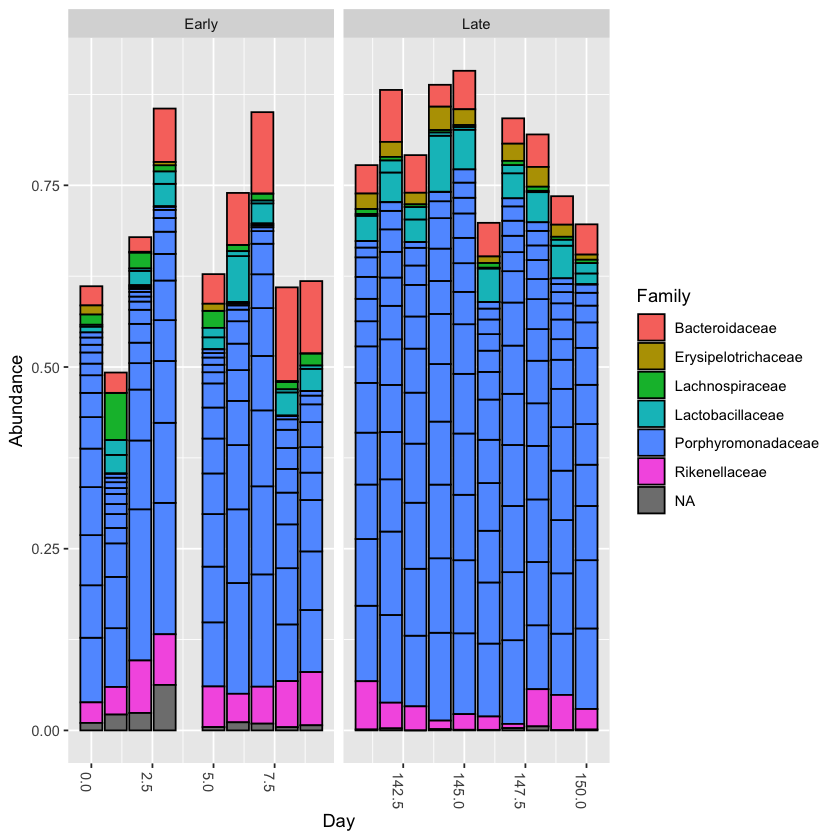

In [28]:
top20 <- names(sort(taxa_sums(ps), decreasing=TRUE))[1:20]
ps.top20 <- transform_sample_counts(ps, function(OTU) OTU/sum(OTU))
ps.top20 <- prune_taxa(top20, ps.top20)
plot_bar(ps.top20, x="Day", fill="Family") + facet_wrap(~When, scales="free_x")

**Figure 7**: Bar plots showing the taxonomic composition of our dataset at the family-level. *Porphyromonadaceaea* are by far the most dominant taxa in both early and late samples. *Lachnospiraceaea* are more represented in early samples and *Erysipelotrichaceae* are more represented in late samples.

### Brief Discussion

From these basic representations, we can see that the early and late mouse samples are largely similar in terms of their taxonomic diversity (Figure 5) and their species compositions (Figures 6 and 7). *Porphyromonadaceae* are common in all samples, which is unsurprising as these bacteria are common fixtures of healthy individuals from the Human Microbiome Project (Huttenhower et al., 2012). The most obvious differences in taxonomic composition between the early and late samples are in regards to the abundance of *Lachnospiraceae* and *Erysipelotrichaceae*. *Erysipelotrichaceae* are known to be increase in their abundance in mouse gut microbiomes as mice switch to diets rich in fat (Greiner & Bäckhed, 2011). *Lachnospiraceae* are thought to be associated with diabetes in obese mice, but it is unclear what role they may have played in these non-obese, newly-weaned mice.

## References

Greiner, T., & Bäckhed, F. (2011). Effects of the gut microbiota on obesity and glucose homeostasis. Trends in Endocrinology & Metabolism, 22(4), 117-123.

Huttenhower, C., Gevers, D., Knight, R. et al. Structure, function and diversity of the healthy human microbiome. Nature 486, 207–214 (2012).

Kameyama, K., & Itoh, K. (2014). Intestinal colonization by a Lachnospiraceae bacterium contributes to the development of diabetes in obese mice. Microbes and environments, ME14054.

Schloss, Patrick D., et al. "Stabilization of the murine gut microbiome following weaning." Gut microbes 3.4 (2012): 383-393.

